Clustering tree morphologies on the basis of topology via [Persistent Homology](https://en.wikipedia.org/wiki/Topological_data_analysis)

The distance metric is pairwise bottleneck distances between persistence diagrams generated from sub-level set filtrations over neuronal morphologies.

See [Li Y, Wang D, Ascoli GA, Mitra P, Wang Y (2017) Metrics for comparing neuronal tree shapes based on persistent homology. PLoS ONE](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0182184) 

for the general approach

In [1]:
import os
import time
import imagej
import numpy as np
import gudhi as gd
from gudhi.representations.vector_methods import Landscape
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, ward, complete, average

In [2]:
# Initialize Fiji with GUI support.
ij = imagej.init(r'C:\Users\cam\Desktop\My_Desktop\Fiji.app', headless=False)
from jnius import autoclass, cast

In [3]:
Context = autoclass('org.scijava.Context')
Tree = autoclass('sc.fiji.snt.Tree')
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
PersistenceAnalyzer = autoclass('sc.fiji.snt.analysis.PersistenceAnalyzer')
TreeAnalyzer = autoclass('sc.fiji.snt.analysis.TreeAnalyzer')
Viewer2D = autoclass('sc.fiji.snt.viewer.Viewer2D')
Viewer3D = autoclass('sc.fiji.snt.viewer.Viewer3D')

MultiViewer2D = autoclass('sc.fiji.snt.viewer.MultiViewer2D')
MultiTreeColorMapper = autoclass('sc.fiji.snt.analysis.MultiTreeColorMapper')
ColorTables = autoclass('net.imagej.display.ColorTables')

In [4]:
diagram_map = {}  # global
tree_map = {}     # global
labels = []       # global

In [5]:
def mydist(a1, a2):
    # bottleneck distance between two persistence diagrams
    # an epsilon may be specified, which greatly accelerates the computation
    return gd.bottleneck_distance(diagram_map[a1[0]], diagram_map[a2[0]], 0.01) 


def get_distance_matrix(cell_ids):
    M = pairwise_distances(cell_ids, metric=mydist)
    
    return M

    
def fetch_reconstructions():
    # Two types of mouse PT neuron from MOs with differing projection patterns descbried in 
    # Economo et al. Nature 2018
    # Group 0 contains the Medulla projecting sub-type. 
    # Group 1 contains the Thalamic projecting sub-type.
    # pre print at https://www.biorxiv.org/content/biorxiv/early/2017/12/05/229260.full.pdf
    group_0 = ['AA0011', 'AA0012', 'AA0115', 'AA0179', 'AA0180', 'AA0181', 'AA0182', 'AA0245', 
              'AA0250', 'AA0576', 'AA0726', 'AA0788', 'AA0791', 'AA0792']
    group_1 = ['AA0039', 'AA0101', 'AA0103', 'AA0105', 'AA0188', 'AA0278', 'AA0390', 'AA0394', 
              'AA0406', 'AA0577', 'AA0599', 'AA0633', 'AA0650', 'AA0781', 'AA0784', 'AA0799', 
              'AA0817', 'AA0837', 'AA0838', 'AA0844']
#     group_2 = ['AA0444', 'AA0490', 'AA0491', 'AA0560', 'AA0611', 'AA0688', 'AA0731', 'AA0804', 
#               'AA0810', 'AA0823', 'AA0827', 'AA0828']
#     group_3 = ['AA0380', 'AA0383', 'AA0423', 'AA0459', 'AA0687', 'AA0704', 'AA0721', 'AA0736', 
#               'AA0811', 'AA0824', 'AA0847', 'AA0848', 'AA0849', 'AA0855']
    groups = [group_0, group_1]
    trees = []
    for num, group in enumerate(groups):
        for cell in group:
            loader = MouseLightLoader(cell)
            if not loader.isDatabaseAvailable(): 
                print("Database not available. Exiting...")
                return
            if not loader.idExists(): 
                print("Id not found in database. Exiting...")
                return
            # Only compare axon topologies
            tree = loader.getTree('axon')
            trees.append(tree)
            tree_map[tree.getLabel()[0:6]] = tree
            tree.setLabel(tree.getLabel().replace('.swc', '') + ' group: ' + str(num))
            labels.append(tree.getLabel())
            
    return trees
    
# def fetch_reconstructions():
#     neuron_dir = r"C:\Users\cam\Desktop\ML-neurons-ALL"
    
#     trees = []
    
#     for n in os.listdir(neuron_dir):
#         swc = neuron_dir + "/" + n
#         tree = Tree(swc)
#         tree_map[tree.getLabel()[0:6]] = tree
#         tree.setLabel(tree.getLabel().replace('.swc', ''))
#         labels.append(tree.getLabel())
#         trees.append(tree)

#     return trees
    
def compute(groups):
    cell_ids = []
    diagrams = []
    for tree in trees:  
        # Obtain Persistence Diagram as an nx2 array where each row corresponds
        # to one birth-death interval.
        print(tree.getLabel())
        diagram = np.asarray(ij.py.from_java(PersistenceAnalyzer(tree).getPersistenceDiagram('radial')))
        print(len(TreeAnalyzer(tree).getTips().toArray()))
        print(diagram)
        key = int(tree.getLabel()[2:6])  # just the numeric part
        diagrams.append(diagram)
        # necessary to pass a 2D numeric array to sklearn.metrics.pairwise_distances
        cell_ids.append([key])
    t0 = time.time()
    ls = Landscape(num_landscapes=5, resolution=100)
    ls.fit(diagrams)
    landscapes = ls.transform(diagrams)
    t1 = time.time()
    print(t1-t0, ' seconds to compute all distances')

    return landscapes


# Ward Hierarchical Clustering
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation="right", labels=labels) 

In [6]:
trees = fetch_reconstructions()

In [7]:
matrix = compute(trees)
for row in matrix:
    print(row)


AA0011 (axon) group: 0
533
[[-12985.15195029     -0.        ]
 [-12854.40142758 -12572.05654162]
 [-12740.79337642 -12591.61055216]
 ...
 [  -252.88810596   -192.86881996]
 [  -219.56702859   -164.38322343]
 [  -219.06106258   -211.51286309]]
AA0012 (axon) group: 0
396
[[-17042.99673606     -0.        ]
 [-16991.01374846 -16708.08203225]
 [-16947.71603653 -16453.61066525]
 [-16931.71432273 -16745.36829009]
 [-16927.08761812 -16625.85540192]
 [-16911.45097903 -16827.74609393]
 [-16886.54689351 -16645.37104793]
 [-16848.21337419 -16264.61434815]
 [-16816.19877661 -13513.90651692]
 [-16814.73136293 -16648.2149913 ]
 [-16811.92755197 -16651.51363387]
 [-16789.70167419 -16768.39499849]
 [-16777.18647782 -16740.31425457]
 [-16768.66244228 -16730.14023078]
 [-16754.66402924 -16637.74427422]
 [-16750.61175634 -16747.11676874]
 [-16724.19316343 -16697.40077098]
 [-16704.35875001 -16697.37610421]
 [-16687.11468925 -16656.17290369]
 [-16667.65980745 -16664.8912655 ]
 [-16640.80313246 -16375.65835

243
[[-17632.21507378     -0.        ]
 [-17544.92404301 -17307.86746232]
 [-17511.01896694 -17304.67530669]
 [-17344.67482672 -17322.20785117]
 [-17197.07854347 -11285.91513998]
 [-17124.99108841 -16824.77423916]
 [-17044.40369345 -16951.0622706 ]
 [-17015.38296797 -16975.69790097]
 [-16902.42266211 -16831.63577893]
 [-16823.68835566 -16533.48759773]
 [-16669.48267899 -14374.60769335]
 [-16639.3378848  -16431.42615919]
 [-16465.49915577 -16373.18307985]
 [-16428.60262151 -13933.84100602]
 [-16398.88029371 -16348.26191761]
 [-16335.90002221 -15302.89375057]
 [-16193.32378676 -16090.14843882]
 [-15760.3063682  -15680.37882159]
 [-15747.69305275  -6524.53843438]
 [-15718.9189355  -15580.73997391]
 [-15704.55196275 -14354.88852207]
 [-15666.3530566   -9981.11126508]
 [-15650.25486088 -15554.97404422]
 [-15607.73546212 -15210.37784078]
 [-15560.61829022 -15158.37616631]
 [-15543.3339238  -15524.57170929]
 [-15443.96606138 -15346.92209174]
 [-15413.69528619 -14893.52179484]
 [-15394.3494706

195
[[-12127.39987365     -0.        ]
 [-11803.25704879  -8038.70677006]
 [-11713.95391265  -6670.20349512]
 [-11530.07936512  -8994.83545105]
 [-11495.66095913 -11241.10860658]
 [-11484.67414217 -11366.92964217]
 [-11434.09155604 -10551.3364974 ]
 [-11428.36643245 -11339.07055414]
 [-11383.02016055 -11340.89224337]
 [-11346.96108184 -11326.15287947]
 [-11346.114119   -10563.57236287]
 [-11309.50936089 -11233.68034561]
 [-11286.24904228 -11233.59291306]
 [-11244.95097871 -11224.79160205]
 [-11232.20612692 -10225.2286643 ]
 [-11209.03497454 -11158.75848108]
 [-11129.22885643 -10434.33305226]
 [-11119.36498727 -11043.46934956]
 [-11070.15294526 -10005.56266724]
 [-11038.1419871  -11006.61026402]
 [-10926.02647797 -10777.44290987]
 [-10864.87022007 -10450.15044389]
 [-10808.08303646  -8040.49228968]
 [-10805.75143256 -10775.00951487]
 [-10771.47773324 -10744.57860039]
 [-10765.2463847  -10730.12891114]
 [-10764.12082885 -10747.44771121]
 [-10678.2003865  -10535.09389722]
 [-10664.2382736

441
[[-12799.48237145     -0.        ]
 [-12446.03908069 -11345.75820343]
 [-12421.48738299  -5500.99879389]
 [-12113.97757568  -7066.57682718]
 [-12088.08535592 -12065.92056808]
 [-12062.09296175 -11913.41723458]
 [-12017.89062476 -11682.54614472]
 [-11990.55410324  -8561.75289103]
 [-11986.76091246  -9133.92674851]
 [-11946.61622876 -11698.45696814]
 [-11891.42355845 -11763.39862152]
 [-11877.68202218 -11812.22978053]
 [-11833.62456249 -11823.67387497]
 [-11833.35674267 -11797.27116956]
 [-11797.58676158 -11306.47046826]
 [-11756.7040787   -8342.62035463]
 [-11738.82985416 -10415.78524688]
 [-11645.09255591 -11542.07847348]
 [-11640.22958603 -10286.52672354]
 [-11623.40204449  -9317.14732967]
 [-11601.34966649 -11062.10013679]
 [-11576.45883998 -10466.71216283]
 [-11572.70280936 -11366.0698484 ]
 [-11538.38791462 -11464.14712436]
 [-11498.86998891 -11470.78713095]
 [-11467.06811307  -8538.62684301]
 [-11437.66944374 -11317.21991257]
 [-11433.2976291  -10141.59419027]
 [-11424.6167322

369
[[-15246.21898376     -0.        ]
 [-15198.58137443 -15159.73946417]
 [-14965.73331314 -14580.08176843]
 [-14913.48060877 -14849.31641048]
 [-14912.72218391 -14881.1009213 ]
 [-14812.20259012 -14695.41820737]
 [-14769.14009425 -14595.11928232]
 [-14123.95189251 -14024.3071319 ]
 [-14030.81047537 -13823.27403565]
 [-13377.81058285 -10193.86032865]
 [-13228.36832889  -6521.08587791]
 [-13208.96912061 -13104.52171396]
 [-13208.22683224 -13068.74716294]
 [-13131.91695228 -12720.02108457]
 [-13102.18281017 -13034.47585819]
 [-13058.53477941 -12960.66345779]
 [-13020.1316811  -12878.06801674]
 [-12996.60872521 -10897.60185897]
 [-12977.66891266 -12732.76229881]
 [-12897.49811415 -12191.59753255]
 [-12871.15013021 -12848.05978828]
 [-12805.5765303  -12746.9571154 ]
 [-12777.33006636 -12756.4403912 ]
 [-12772.50817209 -12634.19229135]
 [-12719.76474227  -7016.74423957]
 [-12697.45991773 -12670.07237797]
 [-12640.26107437 -12601.29213923]
 [-12624.92197871 -11568.92656873]
 [-12597.2961119

370
[[-16497.39507227     -0.        ]
 [-16486.45305058 -16292.28630621]
 [-16321.13217402 -16288.86586458]
 [-16310.03192331 -16280.53920478]
 [-16266.70520611 -13813.56063092]
 [-16251.05473778 -16221.81589315]
 [-16218.42753511 -16187.04024291]
 [-16216.26074684 -16002.76674146]
 [-16175.32122121 -15985.96950425]
 [-16145.32957527 -16038.33393146]
 [-16123.95686893 -15736.27766457]
 [-16079.47281688 -16048.57123101]
 [-16036.41654691 -16026.83452567]
 [-16029.92073052 -15986.32585489]
 [-16029.54884261 -15997.36940951]
 [-16017.36436734 -15946.71408188]
 [-15939.98952831 -15900.68935843]
 [-15802.12123801 -15699.02063643]
 [-15771.11060461 -15704.20579014]
 [-15741.33081373 -15708.88863283]
 [-15731.76119665 -14932.49759106]
 [-15537.53983104 -11513.40413632]
 [-15406.41813977 -13991.44013157]
 [-15380.15650366 -14602.33832297]
 [-15354.56066917 -15100.50677501]
 [-15334.36538344 -14927.70135141]
 [-15314.66427004 -14895.20319699]
 [-15274.2650461  -13846.75165842]
 [-15269.0516603

422
[[-22630.13552357     -0.        ]
 [-22585.627643   -19185.47686519]
 [-22258.22878387 -21967.17176147]
 [-22006.47445103 -21081.85159549]
 [-21770.61813155 -21452.19766426]
 [-21666.53084073 -20685.63368951]
 [-21578.47669941 -20814.21999146]
 [-21574.81453817 -21081.34257206]
 [-21512.34543186 -21454.83896089]
 [-21486.98876122 -21456.13686837]
 [-21440.02807309 -21280.91735111]
 [-21439.83955232 -21230.96115539]
 [-21426.5831298  -21234.67403978]
 [-21389.74917392 -21255.55783674]
 [-21366.89824723 -21261.50504053]
 [-21363.08899734 -21282.83440483]
 [-21359.49994402 -21291.84061213]
 [-21339.58963517 -21269.15218709]
 [-21177.65709364 -21091.82071383]
 [-20990.76635055 -20554.4710853 ]
 [-20918.09535088 -20873.98043704]
 [-20907.19740651 -20849.4609085 ]
 [-20846.54641553 -20000.37999934]
 [-20839.99279391 -20738.45465645]
 [-20799.3158866  -20640.95494017]
 [-20723.47889759 -20647.54030878]
 [-19538.81568337 -19458.84613155]
 [-19498.7104596  -17833.6797883 ]
 [-19199.9870219

535
[[-14046.43216882     -0.        ]
 [-14041.90818461 -14034.07974941]
 [-14015.98068742  -6720.35407343]
 ...
 [  -250.21913922   -218.99315669]
 [  -237.33330925   -208.01419152]
 [  -183.18323035   -158.34525672]]
AA0792 (axon) group: 0
278
[[-12272.05300746     -0.        ]
 [-12010.2863467  -10995.41084684]
 [-11856.3579673  -10649.33851311]
 [-11821.37091489 -11625.8529663 ]
 [-11683.12999328 -11646.33252774]
 [-11671.45886024  -8108.10153891]
 [-11389.31764709  -8804.54372731]
 [-11387.09974038 -11367.53028929]
 [-11335.31254757 -10990.13712224]
 [-11332.32769897  -5418.35576999]
 [-11323.12285575 -11278.85242574]
 [-11289.4489977  -11169.58359289]
 [-11219.47550193 -11024.82566583]
 [-11198.09638222  -7785.26101989]
 [-11161.3339224  -10724.34383732]
 [-11161.22411401 -11131.46203255]
 [-11084.32858699  -8825.92233731]
 [-11076.93379569 -10585.07308346]
 [-11066.11888547 -11035.00625677]
 [-11036.16355557 -11018.17245395]
 [-10994.06851323 -10401.30993117]
 [-10855.70966165 

88
[[-7105.98468293    -0.        ]
 [-7068.89324101 -7047.79211785]
 [-7014.56918973 -6145.38610384]
 [-6934.61641008 -6582.3934204 ]
 [-6916.13531329 -6908.44178295]
 [-6873.5302355  -6627.235827  ]
 [-6690.37949655 -3126.29392977]
 [-6612.55536903 -6246.77868162]
 [-6510.6932559  -6440.39659289]
 [-6487.93126334 -6469.12458451]
 [-6468.26095378 -6207.02920257]
 [-6297.22983933 -6274.20249757]
 [-6284.20315561 -6251.32990156]
 [-6101.81081256 -5361.11379042]
 [-6101.37651459 -4054.88266704]
 [-6091.417052   -3813.62966271]
 [-6024.16254678 -5460.49374147]
 [-5975.22775183 -5944.67826286]
 [-5875.57945293 -5110.04683374]
 [-5857.79605074 -5849.84836737]
 [-5825.41614037 -4093.11445683]
 [-5801.51451274 -5593.1934628 ]
 [-5781.35864725 -5564.75378352]
 [-5757.35659423 -5000.24080607]
 [-5752.96734033 -3401.49787297]
 [-5749.91576195 -5118.06210934]
 [-5739.28668814 -5583.73258328]
 [-5649.88950968 -4719.16426537]
 [-5644.78675375 -5631.52953095]
 [-5639.66975949 -4360.07022366]
 [-5628

254
[[-9365.3790512     -0.        ]
 [-9179.01524312 -8308.37277486]
 [-9057.82276582 -8476.65977997]
 [-9030.84113548 -9019.54789392]
 [-8990.5379329  -8600.01833693]
 [-8703.23288098 -8693.92917551]
 [-8650.11800397 -7534.10671597]
 [-8608.27115339 -8593.46008799]
 [-8594.11654069 -8581.51835699]
 [-8478.99703739 -8463.24254106]
 [-8195.34363899 -8139.07382151]
 [-8161.11957966 -8152.24289142]
 [-8144.74312262 -8139.6712782 ]
 [-8123.79842271 -8107.89292447]
 [-8087.73728145 -8078.17399282]
 [-8062.17333344 -8044.76451673]
 [-8025.98241063 -7979.71333148]
 [-8005.5063413  -7987.9914654 ]
 [-7987.72865204 -7982.66853062]
 [-7983.21504495 -7949.39632181]
 [-7971.31793154 -7964.28515083]
 [-7956.5687075  -7940.90450607]
 [-7898.49869146 -7885.70628535]
 [-7732.27103938 -7724.77282421]
 [-7633.12630728 -7625.74753331]
 [-7612.63338267 -7603.10966506]
 [-7598.97967654 -3960.64014301]
 [-7092.15044811 -5511.04333622]
 [-6813.68638374 -6018.46189167]
 [-6754.150682   -6489.99521508]
 [-671

115
[[-9640.6997149     -0.        ]
 [-9264.60478229 -8962.81585317]
 [-8917.36199953 -7576.96819797]
 [-8898.89643189 -6046.96449822]
 [-8774.51039182 -5829.18033487]
 [-8664.42926136 -8630.12572391]
 [-8596.73672465 -7434.05160246]
 [-8486.82538532 -6443.67129864]
 [-8400.87499532 -7745.36815342]
 [-8295.55571997 -7751.66345795]
 [-8217.1549152  -8037.77274862]
 [-8216.73883525 -4752.70890552]
 [-8206.61733318 -6548.22526411]
 [-8188.37119572 -7707.2728194 ]
 [-8135.24183606 -6416.28235789]
 [-8134.08146089 -8123.88551875]
 [-8105.14790979 -8051.59014849]
 [-8093.96242941 -8038.43893347]
 [-8005.615565   -6627.72142758]
 [-7976.99492806 -7948.26784997]
 [-7971.82112657 -6912.62765916]
 [-7962.20646882 -4797.61043395]
 [-7936.50901475 -7348.60005051]
 [-7929.53662193 -7623.60890449]
 [-7876.73111165 -7528.78872435]
 [-7827.8672648  -7793.36442225]
 [-7822.07871538 -6510.99285186]
 [-7775.31472213 -7583.11377289]
 [-7717.52267259 -7034.54709868]
 [-7691.83967886 -6566.11584432]
 [-767

158
[[-7481.47654373    -0.        ]
 [-7436.40883682 -6785.97066624]
 [-7059.81761241 -4363.79152388]
 [-6796.43998671 -4944.30028376]
 [-6748.63540464 -5886.49614489]
 [-6711.83612027 -5284.59644043]
 [-6675.07977062 -6640.81446167]
 [-6664.30418904 -5776.25583713]
 [-6639.02271935 -6456.40065546]
 [-6636.21542526 -6365.24138069]
 [-6605.59490802 -6582.92655507]
 [-6586.66710417 -6568.57723072]
 [-6578.40755287 -5518.95608896]
 [-6558.78230575 -6542.49241559]
 [-6538.58562252 -6513.51879591]
 [-6534.48212065 -6511.19632502]
 [-6510.78594221 -3949.92548605]
 [-6508.83782703 -6403.12920727]
 [-6426.90570036 -6313.77025574]
 [-6386.58266768 -6367.47721597]
 [-6366.35519859 -5027.36219738]
 [-6325.79433916 -6313.77766798]
 [-6292.42148051 -6275.59749228]
 [-6225.7288438  -4996.40320502]
 [-6203.43176575 -5228.4798427 ]
 [-6194.5727099  -5726.34975504]
 [-6192.29752253 -5334.32745935]
 [-6166.56470617 -5561.5271462 ]
 [-6163.85811352 -5820.34054275]
 [-6157.41998721 -4943.89125152]
 [-613

234
[[-9312.336343      -0.        ]
 [-9023.84467143 -8107.63075762]
 [-9015.64752706 -8398.78797726]
 [-8957.01258467 -8946.3577984 ]
 [-8905.02455406 -8554.86199705]
 [-8855.29802129 -8815.06315127]
 [-8850.93392203 -8838.87862005]
 [-8837.89345872 -8543.99497468]
 [-8816.91145292 -8785.93438846]
 [-8792.05198834 -6442.46991633]
 [-8783.83594689 -8775.27885583]
 [-8768.81034398 -8534.3375645 ]
 [-8745.17767848 -8647.27552373]
 [-8718.86696516 -8682.44902767]
 [-8706.68938182 -8651.66483039]
 [-8694.75427388 -8678.74223513]
 [-8670.06382476 -8661.84129951]
 [-8633.29986458 -8628.66308153]
 [-8583.8117676  -8580.15558922]
 [-8560.06543603 -8551.37025909]
 [-8400.18643393 -7584.52077782]
 [-8392.73086603 -8389.71083357]
 [-8326.53825432 -8321.9786348 ]
 [-8293.67368805 -7752.17951128]
 [-8213.08570705 -5897.38497977]
 [-8210.35723237 -8207.37685901]
 [-8192.86931037 -8189.0712012 ]
 [-8190.25568298 -8186.72499132]
 [-8126.46756703 -7459.00710588]
 [-8108.86782064 -6902.32330807]
 [-809

91
[[-7508.34635134    -0.        ]
 [-7448.35832499 -6850.1673302 ]
 [-7425.13109544 -7138.73456264]
 [-7200.91358894 -6576.77327513]
 [-7153.11073529 -6628.72079382]
 [-7131.65855348 -7048.71548039]
 [-7118.63056779 -7105.61541185]
 [-6799.61620356 -6787.08786748]
 [-6592.79351156 -6558.8436253 ]
 [-6275.57635325 -3803.17105424]
 [-6251.29816722 -4675.41213525]
 [-6191.11350757 -4602.63915802]
 [-6180.30317484 -4842.25715265]
 [-6164.10840515 -5032.79016395]
 [-6160.14099507 -5107.67503877]
 [-6120.28665695 -4678.63232286]
 [-6066.54986932 -5987.34526582]
 [-6038.60352226 -5341.69396718]
 [-6034.2897869  -5783.19098311]
 [-6016.29795453 -5396.85163535]
 [-6006.00306069 -3760.27227947]
 [-5985.90716693 -4882.47458771]
 [-5983.4609604  -5489.01124913]
 [-5971.74660771 -5944.19080357]
 [-5955.88292288 -4701.31141101]
 [-5953.95817473 -5906.58594496]
 [-5950.69037936 -4940.46235408]
 [-5935.03854456 -5718.48550306]
 [-5889.12572959 -5796.45617243]
 [-5882.77596991 -5874.83568046]
 [-5870

0.6635854244232178  seconds to compute all distances
[   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.          302.2023459   619.07209418
  935.94184245 1252.81159073 1569.681339   1886.55108728 2203.42083555
 2520.29058383 2837.1603321  3154.03008038 3470.89982865 3787.76957693
 4104.6393252  4421.50907348 4738.37882175 5055.24857003 5372.1183183
 5688.98806658 6005.85781485 6322.72756313 6639.5973114  6956.46705968
 7273.33680796 7590.20655623 7907.07630451 8223.94605278 8540.81580106
 8857.68554933 917

[[  0.           0.           0.         ... 642.2971283  426.9984125
  132.68679229]
 [  0.           0.           0.         ... 355.7615326  332.68506076
  122.94613031]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ... 136.39777469 418.08812061
  101.21837234]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


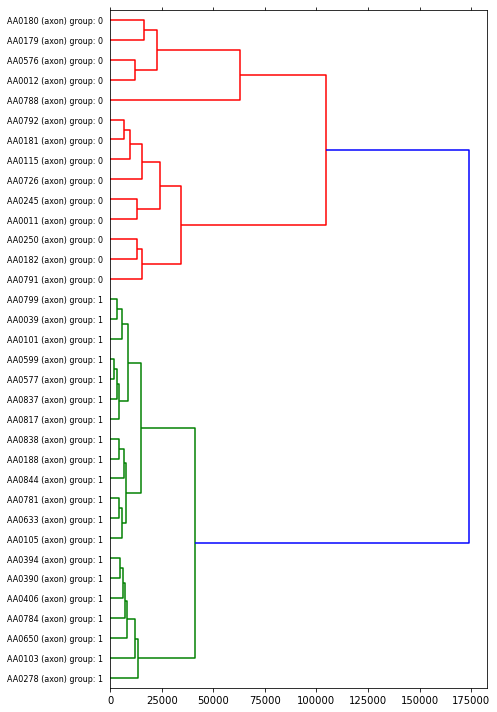

In [8]:
# Perform Hierarchical Clustering on the bottleneck distance matrix and plot a dendrogram
# of the resulting linkage matrix

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(affinity='euclidean', linkage='ward', distance_threshold=0, n_clusters=None)

# fit the model to the precomputed bottleneck distance matrix
model = model.fit(matrix)
print(matrix)
fig, ax = plt.subplots(figsize=(7,10)) # set size
plot_dendrogram(model, truncate_mod='level', p=20)
#plt.show()
#dendrogram(linkage_matrix, orientation='right', labels=labels) 
plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tight_layout()
#plt.savefig('ward_clusters.png', dpi=200)

Lets plot the two neighboring cells in each family

In [9]:
def dbscan(landscapes):
    from sklearn.preprocessing import StandardScaler
    from sklearn import metrics
    labels_true = labels
    #X = StandardScaler().fit_transform()
    print(X)
    print(X.shape)
    # #############################################################################
    # Compute DBSCAN
    db = DBSCAN().fit(X)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    dblabels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(dblabels)) - (1 if -1 in dblabels else 0)
    n_noise_ = list(dblabels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, dblabels))
    print("Completeness: %0.3f" % metrics.completeness_score(labels_true, dblabels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, dblabels))
    print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, dblabels))
    print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, dblabels))

    # #############################################################################
    # Plot result
    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    unique_labels = set(dblabels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (dblabels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

def get_group_viewers(compare):
    viewers = []
    for pair in compare:
        true_labels = []
        v = Viewer3D()
        for t in pair:
            v.addTree(tree_map[t])
            true_labels.append(tree_map[t].getLabel())
            
        v.colorCode(ij.py.to_java(true_labels), 
                    MultiTreeColorMapper.LENGTH, 
                    ColorTables.ICE)
        #v.setViewMode(Viewer3D.ViewMode.SIDE)
        viewers.append(v)
        
    return viewers



In [10]:
compare = [['AA0576', 'AA0012'], ['AA0784', 'AA0278']]
viewers = get_group_viewers(compare)  

In [11]:
viewers[0].show()
viewers[1].show()

<java.awt.Frame at 0x20a5827bc48 jclass=java/awt/Frame jself=<LocalRef obj=0x48f052c0 at 0x20a4e8d9e50>>

In [12]:
dbscan(matrix)

NameError: name 'X' is not defined